# Big Data Project

By Siqi Jiang, Lingchen Kong, Haofu Wu, Guangzhe Zhu 

## Import Spark

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project`").getOrCreate()

In [2]:
spark

## Data Preparation

In [3]:
import pandas as pd
import numpy as np
import pyspark.sql.functions as F

In [4]:
# import review dataset
reviews = spark.read.parquet("s3://amazon-reviews-pds/parquet")

In [6]:
reviews.limit(1).toPandas()

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,product_category
0,US,12102864,R12TI52J6GAMEV,1622030532,531977143,Red Hot and Holy: A Heretic’s Love Story,5,3,4,N,Y,Like a love letter to my Soul,Sera's new book acts like a jailbreak for the ...,2013-07-13,2013,Books


In [7]:
reviews.count()

160796570

In [8]:
print('US', reviews.filter("marketplace = 'US'").count())
print('DE', reviews.filter("marketplace = 'DE'").count())
print('FR', reviews.filter("marketplace = 'FR'").count())
print('UK', reviews.filter("marketplace = 'UK'").count())
print('JP', reviews.filter("marketplace = 'JP'").count())

US 157893444
DE 679121
FR 254080
UK 1707494
JP 262431


In [42]:
reviews.select('product_category').distinct().count()

43

In [10]:
reviews.select('product_category').distinct().show()

+--------------------+
|    product_category|
+--------------------+
|                  PC|
|             Kitchen|
|                Home|
|            Wireless|
|               Video|
| Digital_Video_Games|
|Digital_Video_Dow...|
|             Luggage|
|              Sports|
|         Video_Games|
|  Mobile_Electronics|
|  Home_Entertainment|
|Digital_Ebook_Pur...|
|                Baby|
|             Apparel|
|    Major_Appliances|
|             Grocery|
|               Tools|
|         Electronics|
|            Outdoors|
+--------------------+
only showing top 20 rows



In [12]:
us_reviews = reviews.filter("marketplace = 'US'")

In [59]:
us_sample_reviews.printSchema()

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- product_category: string (nullable = true)



In [31]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [53]:
#from datetime import datetime
#def month_fun(day):
#    s = datetime.strptime(day, '%Y-%m-%d').strftime('%Y-%m')
#    return s

In [54]:
#udf_month = udf(lambda day: month_fun(day), TimestampType())

In [55]:
#us_sample_reviews.withColumn("year_month", udf_month(us_sample_reviews.review_date))

DataFrame[marketplace: string, customer_id: string, review_id: string, product_id: string, product_parent: string, product_title: string, star_rating: int, helpful_votes: int, total_votes: int, vine: string, verified_purchase: string, review_headline: string, review_body: string, review_date: date, year: int, product_category: string, year_month: timestamp]

# 1 General b.

In [92]:
# create month column
us_reviews = us_reviews.withColumn("month",month(col("review_date")))

In [98]:
# aggreagate verified_purchase
us_reviews_verified = us_reviews.groupBy("year","month","verified_purchase").agg(F.count("*").alias("vcount")).orderBy("year","month","verified_purchase")

In [111]:
verified_review = us_reviews_verified.toPandas()

In [162]:
verified_review.head()

,year,month,verified_purchase,vcount
0,1995,6,N,2
1,1995,7,N,23
2,1995,8,N,22
3,1995,9,N,28
4,1995,10,N,46


In [117]:
verified_review2 = verified_review.groupby(["year", "month"], sort=False)["vcount"].sum().reset_index(name ='Total_Amount')

In [122]:
verified_total = pd.merge(verified_review, verified_review2, on=['year', 'month'], how='inner')

In [126]:
verified_total.head()

,year,month,verified_purchase,vcount,Total_Amount
0,1995,6,N,2,2
1,1995,7,N,23,23
2,1995,8,N,22,22
3,1995,9,N,28,28
4,1995,10,N,46,46


In [133]:
verified_total['verified_percentage'] = verified_total.apply (lambda row: row.vcount/row.Total_Amount, axis=1)

In [145]:
verified_total['year-month'] = pd.to_datetime(verified_total[['year', 'month']].assign(Day=1))

In [147]:
verified_total.head(10)

,year,month,verified_purchase,vcount,Total_Amount,verified_percentage,year-month
0,1995,6,N,2,2,1.000000,1995-06-01
1,1995,7,N,23,23,1.000000,1995-07-01
2,1995,8,N,22,22,1.000000,1995-08-01
3,1995,9,N,28,28,1.000000,1995-09-01
4,1995,10,N,46,46,1.000000,1995-10-01
5,1995,11,N,49,50,0.980000,1995-11-01
6,1995,11,Y,1,50,0.020000,1995-11-01
7,1995,12,N,38,39,0.974359,1995-12-01
8,1995,12,Y,1,39,0.025641,1995-12-01
9,1996,1,N,69,69,1.000000,1996-01-01


In [152]:
verified_total_Y = verified_total[(verified_total["year"]>= 2006)&(verified_total["year"]<= 2015)&(verified_total["verified_purchase"] == "Y")]

In [174]:
verified_total_Y.head()

,year,month,verified_purchase,vcount,Total_Amount,verified_percentage,year-month
245,2006,1,Y,18208,130658,0.139356,2006-01-01
247,2006,2,Y,25551,133788,0.190981,2006-02-01
249,2006,3,Y,34321,164052,0.209208,2006-03-01
251,2006,4,Y,8315,61715,0.134732,2006-04-01
253,2006,5,Y,12514,104536,0.119710,2006-05-01


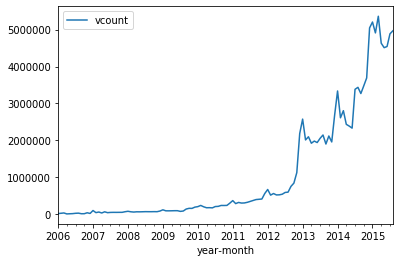

In [153]:
import matplotlib.pyplot as plt

# gca stands for 'get current axis'
ax = plt.gca()

verified_total_Y.plot(kind='line',x='year-month',y='vcount',ax=ax)

plt.show()

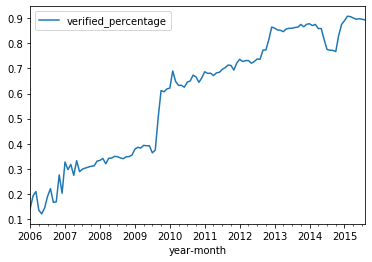

In [154]:
# gca stands for 'get current axis'
ax = plt.gca()

verified_total_Y.plot(kind='line',x='year-month',y='verified_percentage',ax=ax)

plt.show()

# 1 General d.

In [157]:
# aggreagate verified_purchase
us_reviews_vine = us_reviews.groupBy("year","month","vine").agg(F.count("*").alias("vcount")).orderBy("year","month","vine")
us_reviews_vine = us_reviews_vine.toPandas()

/home/hadoop/miniconda/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [163]:
us_reviews_vine.head()

,year,month,vine,vcount
0,1995,6,N,2
1,1995,7,N,23
2,1995,8,N,22
3,1995,9,N,28
4,1995,10,N,46


In [178]:
vine_review = us_reviews_vine.groupby(["year", "month"], sort=False)["vcount"].sum().reset_index(name ='Total_Amount')

In [179]:
vine_total = pd.merge(us_reviews_vine, vine_review, on=['year', 'month'], how='inner')

In [180]:
vine_total['vine_percentage'] = verified_total.apply (lambda row: row.vcount/row.Total_Amount, axis=1)
vine_total['year-month'] = pd.to_datetime(verified_total[['year', 'month']].assign(Day=1))

In [181]:
vine_total_Y = vine_total[(vine_total["year"]>= 2006)&(vine_total["year"]<= 2015)&(vine_total["vine"] == "Y")]

In [186]:
vine_total_Y.head()

,year,month,vine,vcount,Total_Amount,vine_percentage,year-month
138,2006,11,Y,1,142924,0.923261,2001-08-01
144,2007,4,Y,1,123342,0.925341,2001-11-01
149,2007,8,Y,10,167556,0.077670,2002-01-01
151,2007,9,Y,174,163716,0.082811,2002-02-01
153,2007,10,Y,230,164696,0.085829,2002-03-01


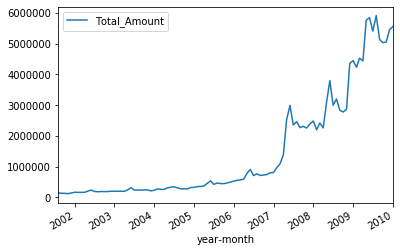

In [183]:
# gca stands for 'get current axis'
ax = plt.gca()

vine_total_Y.plot(kind='line',x='year-month',y='Total_Amount',ax=ax)

plt.show()

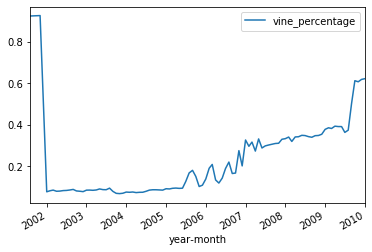

In [184]:
# gca stands for 'get current axis'
ax = plt.gca()

vine_total_Y.plot(kind='line',x='year-month',y='vine_percentage',ax=ax)

plt.show()

# 1 General a.

In [205]:
us_reviews_count = us_reviews.groupBy("year","month").agg(F.count("*").alias("count")).orderBy("year","month").toPandas()
us_reviews_count['year-month'] = pd.to_datetime(us_reviews_count[['year', 'month']].assign(Day=1))

In [207]:
ten_year_reviews = us_reviews_count[(us_reviews_count["year"]>= 2006)&(us_reviews_count["year"]<= 2015)]

In [208]:
ten_year_reviews.head(10)

,year,month,count,year-month
125,2006,1,130658,2006-01-01
126,2006,2,133788,2006-02-01
127,2006,3,164052,2006-03-01
128,2006,4,61715,2006-04-01
129,2006,5,104536,2006-05-01
130,2006,6,112454,2006-06-01
131,2006,7,132885,2006-07-01
132,2006,8,131971,2006-08-01
133,2006,9,82098,2006-09-01
134,2006,10,83790,2006-10-01


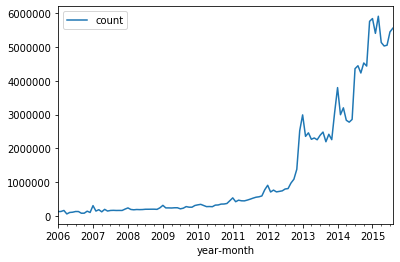

In [209]:
# gca stands for 'get current axis'
ax = plt.gca()

ten_year_reviews.plot(kind='line',x='year-month',y='count',ax=ax)

plt.show()

# 1 General c.

In [93]:
us_reviews.createOrReplaceTempView("review_tbl")

In [233]:
verified_rating = spark.sql("""select verified_purchase, avg(star_rating), count(*) as count
from review_tbl
group by verified_purchase
order by count
""")

In [234]:
verified_rating = verified_rating.toPandas()

In [235]:
verified_rating

,verified_purchase,avg(star_rating),count
0,N,4.104536,35120356
1,Y,4.233064,122773088


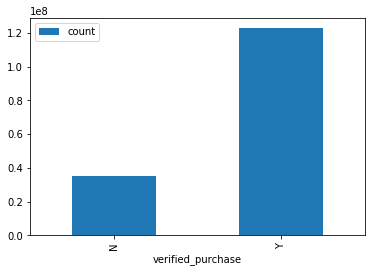

In [236]:
# a simple bar plot
verified_rating.plot(kind='bar',x='verified_purchase',y='count')

# 1 General e.

In [226]:
vine_rating = spark.sql("""select vine, avg(star_rating), count(*) as count
from review_tbl
group by vine
order by count
""")

In [227]:
vine_rating = vine_rating.toPandas()

In [229]:
vine_rating

,vine,avg(star_rating),count
0,Y,4.083619,673207
1,N,4.204993,157220237


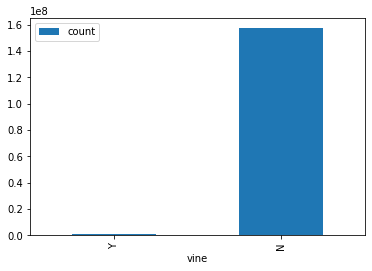

In [232]:
# a simple bar plot
vine_rating.plot(kind='bar',x='vine',y='count')

# 1 General f.

In [211]:
top_review = us_reviews.groupBy("product_category").count().sort(col("count").desc()).toPandas()

In [212]:
top10_category_review = top_review.head(10)

In [213]:
top10_category_review

,product_category,count
0,Books,20370130
1,Digital_Ebook_Purchase,18871305
2,Wireless,9024783
3,PC,6965595
4,Mobile_Apps,6507959
5,Home,6223566
6,Video_DVD,6166026
7,Apparel,5906455
8,Music,5530282
9,Health_&_Personal_Care,5332520


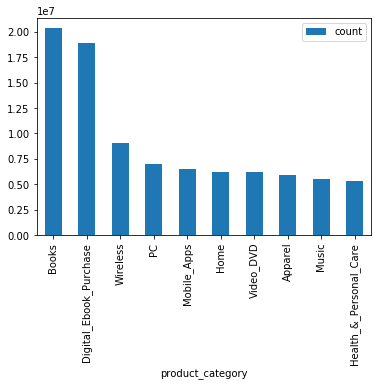

In [214]:
# a simple bar plot
top10_category_review.plot(kind='bar',x='product_category',y='count')

In [240]:
spark.sql(
    """select product_title, count(*) as review_num from review_tbl 
    where product_category = 'Books' and year = 2005
    group by product_title
    order by review_num DESCju
    limit 1""").toPandas()

,product_title,review_num
0,Harry Potter and the Half-Blood Prince (Book 6),2364


In [ ]:
spark.stop()